Clustering Images with Mixture of Gaussians

In [54]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal as mvn
import gmm
from IPython.display import display
from io import BytesIO

There are 4 different category of images - cloudy sky, sunset, rivers, forests

Image Dataset Processing

In [2]:
#Images dataset
images = []
images_sky = []
images_sunset = []
images_river = []
images_forests = []
for filename in os.listdir('images/cloudy_sky'):
    img = Image.open(os.path.join('images/cloudy_sky',filename))
    images_sky.append(np.array(img))
    
    
for filename in os.listdir('images/sunsets'):
    img = Image.open(os.path.join('images/sunsets',filename))
    images_sunset.append(np.array(img))
    
for filename in os.listdir('images/rivers'):
    img = Image.open(os.path.join('images/rivers',filename))
    images_river.append(np.array(img))    

for filename in os.listdir('images/trees_and_forest'):
    img = Image.open(os.path.join('images/trees_and_forest',filename))
    images_forests.append(np.array(img))    
    
images = images_sky + images_forests + images_river + images_sunset   
    
    

Images above contains 256 pixels, each pixel has values in Red channel, blue channel and green channel
for each of the above images, we will have 3 features, namely,R,G and B which will be obtained by averaging values of each channel, each image is 256 by 256 by 3, means average of 256 * 256 pixel will be taken as a pixel representing a single image

In [3]:
im_dataset = pd.DataFrame(columns = ['R','G','B'],dtype=float)
for i in range(len(images)):
    r,g,b = np.mean(images[i][:,:,0])/256.0,np.mean(images[i][:,:,1])/256.0,np.mean(images[i][:,:,2])/256.0
    im_dataset.loc[i,'R'] = r
    im_dataset.loc[i,'G'] = g
    im_dataset.loc[i,'B'] = b

In [4]:
im_dataset.head()


,R,G,B
0,0.528536,0.536798,0.546718
1,0.416127,0.567949,0.760861
2,0.345726,0.470252,0.647845
3,0.529008,0.541079,0.543306
4,0.439874,0.471199,0.498986


In [5]:
im_dataset.describe()

,R,G,B
count,1328.000000,1328.000000,1328.000000
mean,0.431148,0.423243,0.389701
std,0.126294,0.132077,0.183803
min,0.082465,0.070930,0.015523
25%,0.340887,0.333139,0.255697
50%,0.421639,0.421318,0.373932
75%,0.507995,0.503143,0.507979
max,0.864396,0.937366,0.952862


Initialization of initial cluster parameters: Let's take 4 images to be our initial cluster centers, and let's initialize the covariance matrix of each cluster to be diagonal with each element equal to the sample variance from the full data. As in our test on simulated data, we'll start by assuming each mixture component has equal weight.

In [16]:
#Initializing inital means, covariances, weights of clusters, number of clusters is taken equal to 4
init_means = [im_dataset.iloc[x].values for x in np.random.choice(len(images), 4, replace=False)]
init_weights = [1/4] * 4
init_cov = [np.diag([im_dataset['R'].var(), im_dataset['G'].var(), im_dataset['B'].var()])] * 4
im_data = im_dataset.values

In [22]:
#Running the EM algorithm
out_results = gmm.EM(im_data,init_means,init_cov,init_weights,iters = 100, threshold=1e-4)


Iteration: 0
Log likelihood:4293


In [24]:
print("Final weights of each component in the mixture: " + str(out_results['Final weights']) )

Final weights of each component in the mixture: [0.28870933947632194, 0.2853905969176269, 0.1953335033463834, 0.23056656025966776]


Visualizing Convergence of EM algorithm

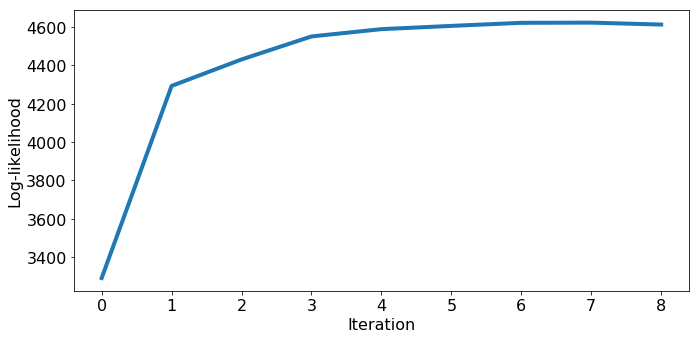

In [27]:
#Log likelihood values vs iterations
plt.figure(figsize = (10,5))
ll = out_results['Log likelihoods']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.show()

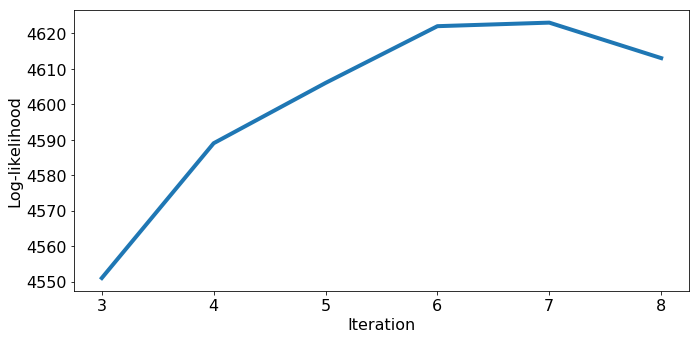

In [29]:
#Lets zoom in and see what happens during the last few iterations
plt.figure(figsize = (10,5))
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.show()

The log likelihhod increases much during the first 3 iterations, after that, the rate of increase of Log likelihood decreases.

We can evaluate the quality of our clustering by taking a look at a few images that 'belong' to each cluster. We hope to find that the clusters discovered by our EM algorithm correspond to different image categories.Here, our clusters are described by probability distributions (specifically, Gaussians) rather than single points, and our model maintains some uncertainty about the cluster assignment of each observation.

we can find the cluster assignment of an observation by taking the Gaussian component for which that observation's log likelihood is highest. We'll use this fact to find the top images in a cluster.

In [39]:
weights = out_results['Final weights']
means = out_results['Final means']
covariances = out_results['Final covariances']
N = len(im_data) # number of images
K = len(means) # number of clusters

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k]*mvn.pdf(im_data[i,:], mean=means[k], cov=covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

d = {'assignments':assignments, 'probs':probs, 'image': images}

In [61]:
assign = pd.DataFrame(d)

In [78]:
#utility functions to get top images of each cluster
def get_top_images(assignments, cluster, k=5):
    top_images = assign[assign['assignments']==cluster]
    top_images = top_images.nlargest(k,'probs')
    return top_images['image']

def display_images(images):
    for image in images:
        display(Image.fromarray(image,'RGB'))

Component 0


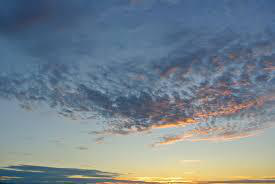

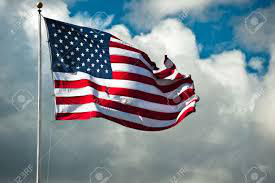

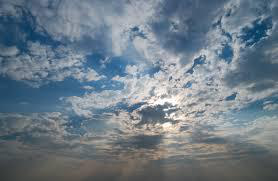

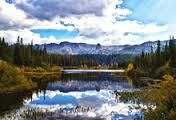

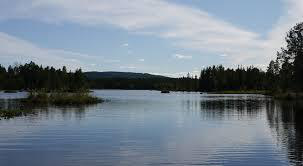



Component 1


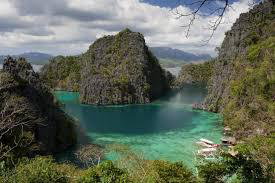

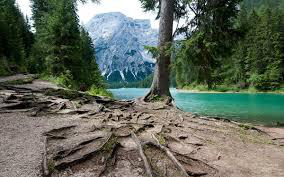

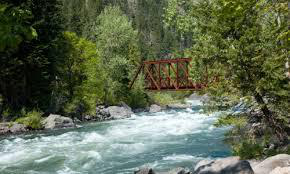

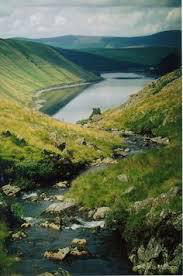

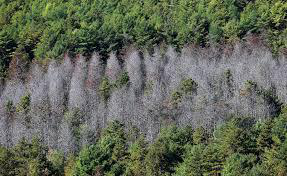



Component 2


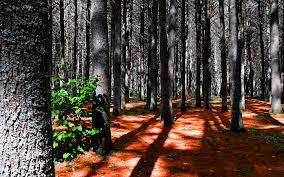

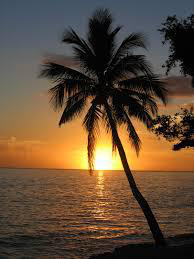

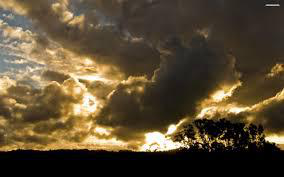

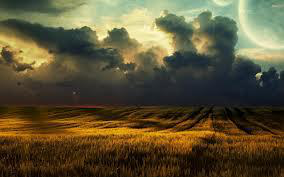

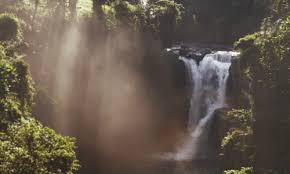



Component 3


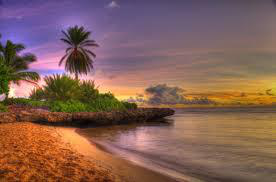

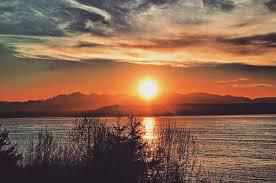

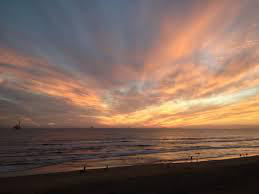

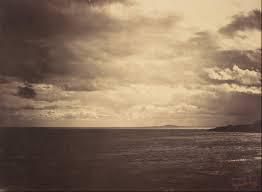

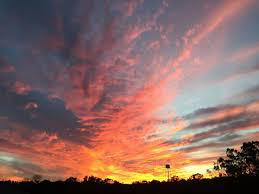

In [79]:
for component_id in range(4):
    print('Component {0:d}'.format(component_id))
    images = get_top_images(assign, component_id)
    display_images(images)
    print('\n')

Hence we see can judge the quality of clusters evaluated